In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import asyncio
from functools import wraps
import openai
from faker import Faker
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../privacypromptrewriting')
from utils import *
from tqdm.auto import tqdm
from pyfpe_ff3 import FF3Cipher

In [114]:
import openai
openai.api_key = "SECRET_KEY"

N = {'bmi': 45} 
epsilon = [.5,1,1.5,2,2.5]

num_runs= 50
key = "EF4359D8D580AA4F7F036D6F04FC6A94"
tweak = "D8E7920AFA330A73" 
c = FF3Cipher(key, tweak,allow_small_domain=True, radix=10)

In [16]:
import asyncio
from functools import wraps
async def query_llm(text,system_text):
    response = openai.ChatCompletion.create(
              model='gpt-4-1106-preview',
              messages=[
                {
                  "role": "system",
                  "content": system_text
                },
                {
                  "role": "user",
                  "content": text 
                },
              ],
              temperature=0,
              max_tokens=5,
              top_p=.3,
              frequency_penalty=0,
              presence_penalty=0
            )
    return response
def retry(exceptions, tries=3, delay=1):
    def decorator(func):
        @wraps(func)
        async def wrapper(*args, **kwargs):
            current_tries = 0
            while current_tries < tries:
                try:
                    return await func(*args, **kwargs)
                except exceptions as e:
                    print(f"Exception caught: {e}")
                    await asyncio.sleep(delay)
                    current_tries += 1
            raise Exception("Max retries exceeded, failed to execute function.")

        return wrapper

    return decorator

# Applying retry decorator to handle 502 Bad Gateway
@retry(Exception, tries=3, delay=1)
async def query_with_retry(text,system_text):
    return await query_llm(text,system_text)

In [9]:
# Template:
# Jon Smith is a 50 year old man, with bmi 24, blood pressure of 120/80mmHG, heart rate of 60bpm, and temperature of 36.6 degrees celsius. 
# Is the patient healthy and based on the vitals what concerns should be raised to their physician?

# vital statistics
bmis = [20, 25, 30, 45]
bp_systoles = [100, 120, 130, 140]
bp_diastoles = [60, 80, 90, 100]
heart_rates = [60, 75, 90, 120]
ages = [15, 30, 55, 70]

In [92]:
# vital statistics
# bmis = [20, 25, 30, 45]
heights = [165, 175, 185, 195]
weights = [55, 65, 75, 90]
# bp_systoles = [100, 120, 130, 140]
# bp_diastoles = [60, 80, 90, 100]
# heart_rates = [60, 75, 90, 120]
# ages = [15, 30, 55, 70]

In [18]:
# Create a 2 by 2 figure plot
# Data is already cached in datasets/med-qa
"""
Experiment 3: Varying BMI via height and weight.
"""
output_dataset = np.zeros((num_runs,len(heights),len(epsilon)))
age_dataset = np.zeros((num_runs,len(heights), len(epsilon)))
bmi_dataset = np.zeros((num_runs,len(heights), len(epsilon)))
height_dataset = np.zeros((num_runs,len(heights), len(epsilon)))
weight_dataset = np.zeros((num_runs,len(heights), len(epsilon)))
# heart_rate_dataset = np.zeros((num_runs,len(bmis), len(epsilon)))

system_text = "You are a medical assistant that answers questions from a user about their health based on their vitals with either 'Yes' or 'No'. For example, 'User: Jon Smith is a 30 year old man who has a height of 165cm, weight of 70kg and bmi 25.7. Is the patient healthy based on their vitals?. Assistant: '"
names = ['output', 'bmi', 'age', 'height', 'weight']
data_weight = {weight: {name: np.zeros((num_runs,len(heights),len(epsilon))) for name in names} for weight in weights}

for weight in weights:
    for i, height in tqdm(zip(range(len(heights)), heights), total=len(heights)):
        bmi = (10000*weight)/(height**2)
    #     text = f'User: Jon Smith is a {age} year old man, with bmi {bmi}, blood pressure of {bp_sys}/{bp_dia}mmHG and heart rate of {heart_rate}bpm. Is the patient healthy based on their vitals?. Assistant: '                        
        text = f'User: Jon Smith is a 30 year old man, who has a height of {height}cm, weight of {weight}kg and bmi {bmi:.2f}. Is the patient healthy based on their vitals?. Assistant: '                        
        entities = extract_entities_regex(text, fields=['height', 'weight'])

        for j in range(len(epsilon)):
            output_fraction = []
            outputs = []
            inputs = []
            age_inputs = []
            bmi_inputs = []
            height_inputs = []
            weight_inputs = []
            heart_rate_inputs = []

            for k in range(num_runs):
                encrypted_entities = generate_encrypted_entities_regex(entities, N, epsilon[j], c,)
                new_bmi = (10000*encrypted_entities['weight'])/(encrypted_entities['height']**2)
                encrypted_entities['bmi'] = new_bmi
                new_text = update_entities_regex(text, encrypted_entities)
                completion = await query_with_retry(new_text,system_text)
                response = completion.choices[0]['message']['content'].replace('.','')
                if response=='Yes': outputs.append(1)
                else: outputs.append(0)
                all_extracted_entities = extract_entities_regex(new_text, fields=['age', 'bmi', 'height', 'weight'])
                bmi_inputs.append(float(all_extracted_entities['bmi']))
                height_inputs.append(float(all_extracted_entities['height']))
                weight_inputs.append(float(all_extracted_entities['weight']))
                age_inputs.append(float(all_extracted_entities['age']))

            data_weight[weight]['output'][:,i,j] = outputs
            data_weight[weight]['bmi'][:,i,j] = bmi_inputs
            data_weight[weight]['height'][:,i,j] = height_inputs
            data_weight[weight]['weight'][:,i,j] = weight_inputs
            data_weight[weight]['age'][:,i,j] = age_inputs

  0%|          | 0/4 [00:00<?, ?it/s]

Exception caught: The server had an error while processing your request. Sorry about that! {
  "error": {
    "message": "The server had an error while processing your request. Sorry about that!",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that!', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Tue, 30 Jan 2024 19:18:42 GMT', 'Content-Type': 'application/json', 'Content-Length': '176', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-4-1106-preview', 'openai-organization': 'alta-cognita', 'openai-processing-ms': '1305', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '10000', 'x-ratelimit-limit-tokens': '600000', 'x-ratelimit-remaining-requests': '9999', 'x-ratelimit-remaining-tokens': '599880', 'x-ratelimit-reset-requests': '6ms', 'x

  0%|          | 0/4 [00:00<?, ?it/s]

Exception caught: The server had an error while processing your request. Sorry about that! {
  "error": {
    "message": "The server had an error while processing your request. Sorry about that!",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that!', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Tue, 30 Jan 2024 19:21:05 GMT', 'Content-Type': 'application/json', 'Content-Length': '176', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-4-1106-preview', 'openai-organization': 'alta-cognita', 'openai-processing-ms': '2070', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '10000', 'x-ratelimit-limit-tokens': '600000', 'x-ratelimit-remaining-requests': '9999', 'x-ratelimit-remaining-tokens': '599880', 'x-ratelimit-reset-requests': '6ms', 'x

  0%|          | 0/4 [00:00<?, ?it/s]

Exception caught: The server had an error while processing your request. Sorry about that! {
  "error": {
    "message": "The server had an error while processing your request. Sorry about that!",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that!', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Tue, 30 Jan 2024 19:24:28 GMT', 'Content-Type': 'application/json', 'Content-Length': '176', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-4-1106-preview', 'openai-organization': 'alta-cognita', 'openai-processing-ms': '2067', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '10000', 'x-ratelimit-limit-tokens': '600000', 'x-ratelimit-remaining-requests': '9999', 'x-ratelimit-remaining-tokens': '599880', 'x-ratelimit-reset-requests': '6ms', 'x

  0%|          | 0/4 [00:00<?, ?it/s]

Exception caught: The server had an error while processing your request. Sorry about that! {
  "error": {
    "message": "The server had an error while processing your request. Sorry about that!",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that!', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Tue, 30 Jan 2024 19:25:23 GMT', 'Content-Type': 'application/json', 'Content-Length': '176', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-4-1106-preview', 'openai-organization': 'alta-cognita', 'openai-processing-ms': '206', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '10000', 'x-ratelimit-limit-tokens': '600000', 'x-ratelimit-remaining-requests': '9999', 'x-ratelimit-remaining-tokens': '599880', 'x-ratelimit-reset-requests': '6ms', 'x-

In [19]:
# Dump data
# import pickle
# with open('../datasets/med-qa/format_eval_med_data_ht_wt_bmi.pkl', 'wb') as fp:
#     pickle.dump(data_weight, fp)

In [93]:
# Load data
import pickle
with open('../datasets/med-qa/format_eval_med_data_ht_wt_bmi_gpt4o_updated_epsilon.pkl', 'rb') as fp:
    data_weight = pickle.load(fp)

In [104]:
data_weight[55]['bmi'][:,0,0]

array([18.66, 19.23, 20.83, 21.3 , 20.57, 22.27, 23.61, 18.78, 19.57,
       20.32, 23.34, 17.65, 19.47, 19.23, 17.72, 18.73, 23.8 , 21.3 ,
       20.32, 19.95, 18.14, 21.76, 18.73, 21.63, 19.47, 21.77, 23.61,
       18.42, 19.61, 21.09, 19.95, 20.7 , 19.47, 20.2 , 20.7 , 17.36,
       20.32, 19.71, 22.15, 19.47, 17.65, 24.69, 18.73, 21.36, 18.  ,
       19.2 , 20.7 , 18.59, 20.2 , 25.78])

In [105]:
merged_heights = np.concatenate([data_weight[55]['height'], 
                                 data_weight[65]['height'], 
                                 data_weight[75]['height'], 
                                 data_weight[90]['height']], axis=0)
merged_heights.shape

(200, 4, 5)

In [106]:
merged_weights = np.concatenate([data_weight[55]['weight'], 
                                 data_weight[65]['weight'], 
                                 data_weight[75]['weight'], 
                                 data_weight[90]['weight']], axis=0)
merged_weights.shape

(200, 4, 5)

In [107]:
merged_bmi = np.concatenate([data_weight[55]['bmi'], 
                                 data_weight[65]['bmi'], 
                                 data_weight[75]['bmi'], 
                                 data_weight[90]['bmi']], axis=0)
merged_bmi.shape

(200, 4, 5)

In [108]:
data_weight[55]['height'].shape

(50, 4, 5)

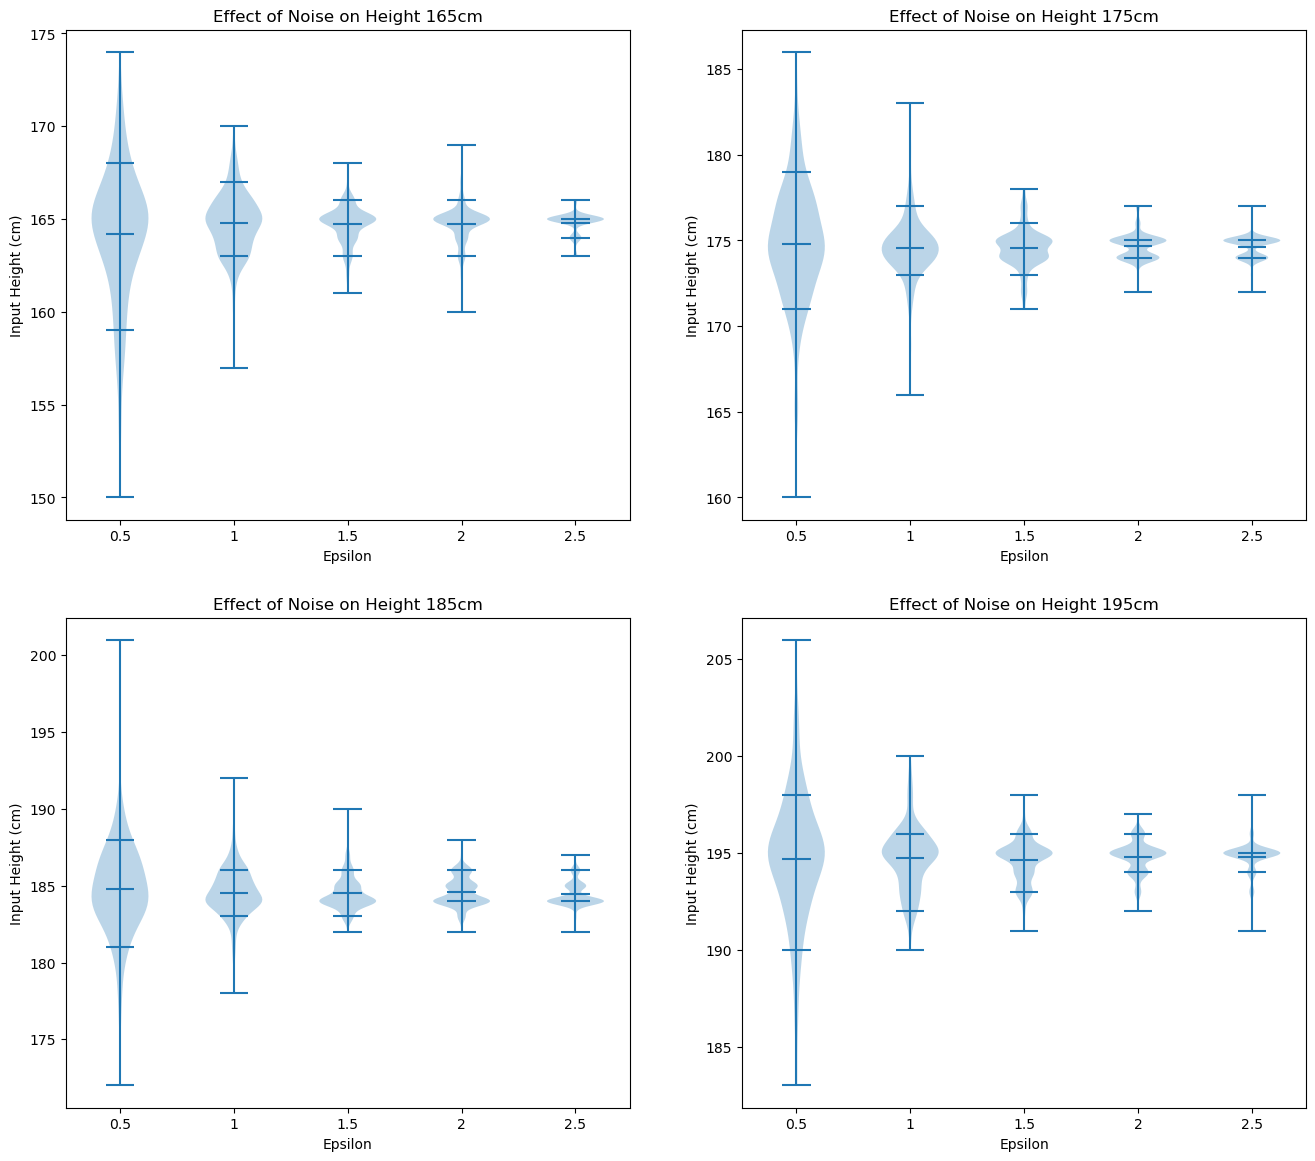

In [109]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(heights):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(merged_heights[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Height (cm)")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Height %scm" % salary)
plt.savefig('medqa_height_noise_violin.png')
plt.show()

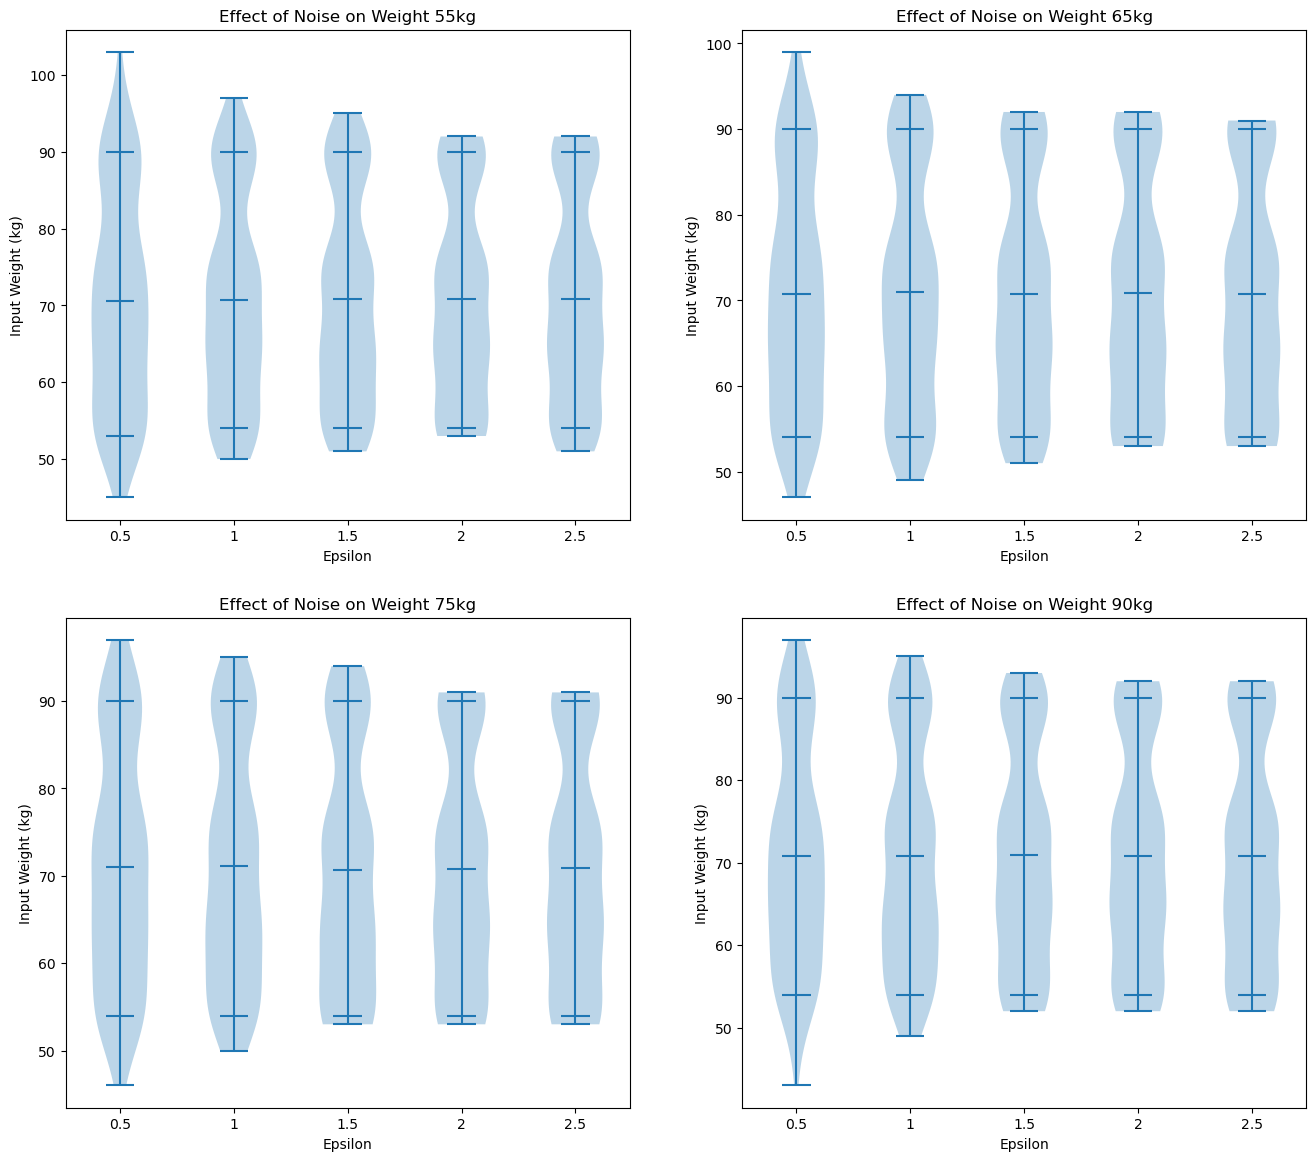

In [110]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(weights):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(merged_weights[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Weight (kg)")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Weight %skg" % salary)
plt.savefig('medqa_weight_noise_violin.png')
plt.show()

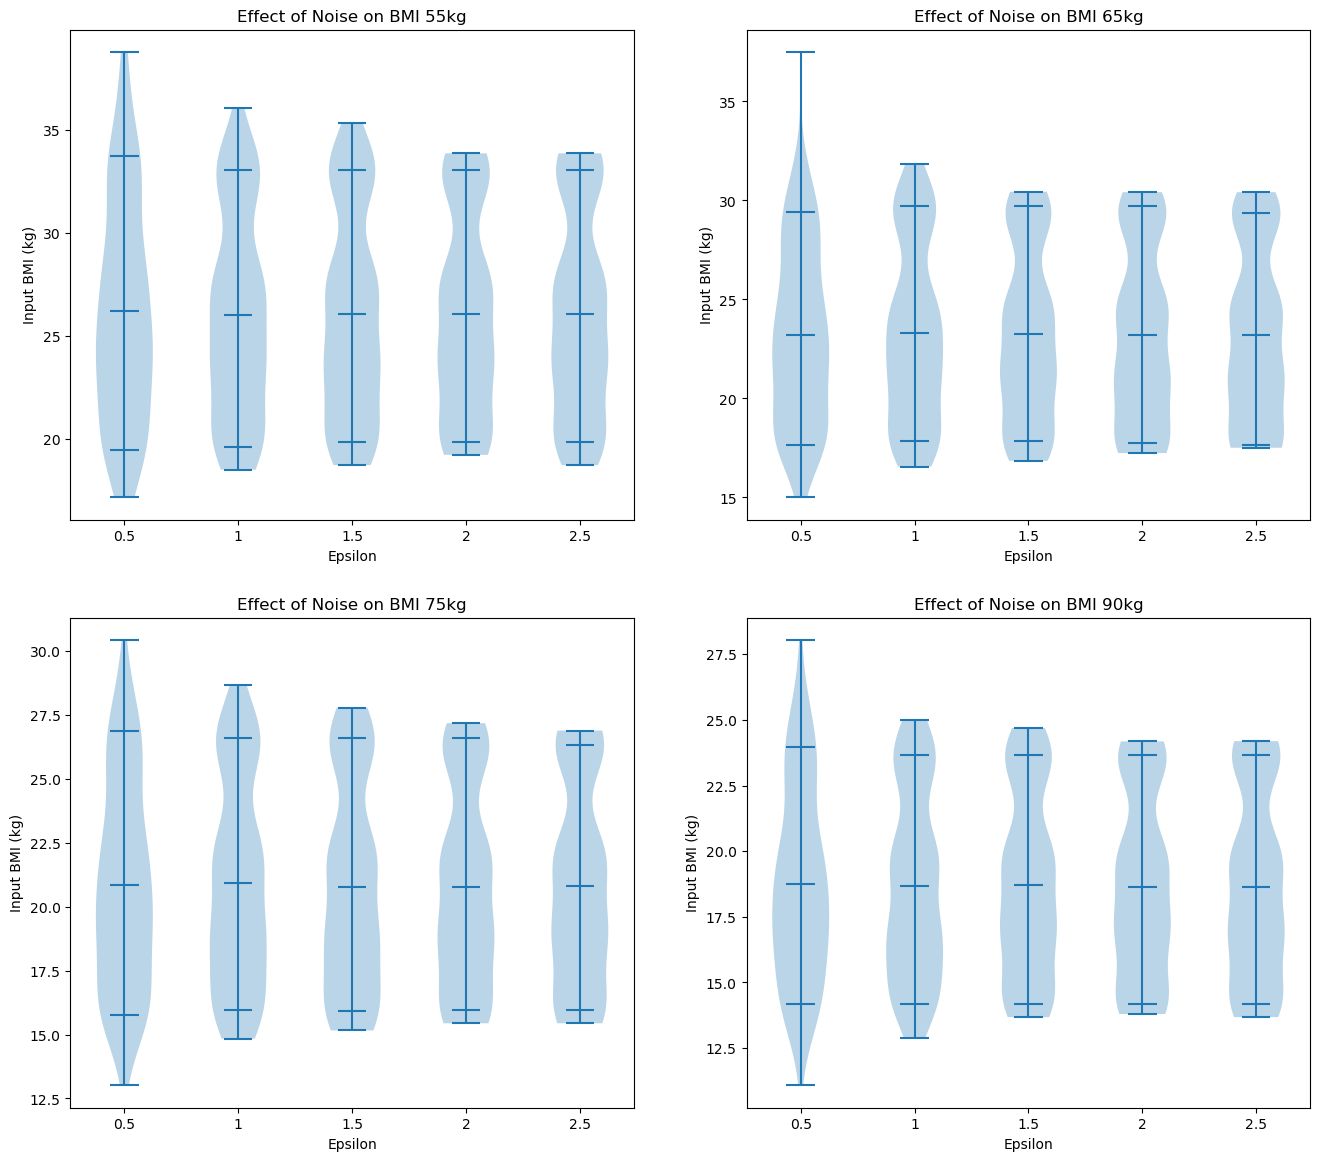

In [111]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(weights):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(merged_bmi[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input BMI (kg)")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on BMI %skg" % salary)
plt.savefig('medqa_bmi_noise_violin.png')
plt.show()

In [115]:
import numpy as np
output_list = []
height_list = []
noise_list = []
weight_list = []
bmi_list = []
bmi_list_squared = []
for z, weight in enumerate(weights):
    for j, height in enumerate(heights):
        for k, epsilons in enumerate(epsilon):
            for i in range(num_runs):
                output = data_weight[weight]['output'][i, j, k]
                output_list.append(output)
                height_list.append(data_weight[weight]['height'][i, j, k])
                weight_list.append(data_weight[weight]['weight'][i, j, k])
#                 height_list.append(height)
#                 weight_list.append(weight)
                bmi_list.append(data_weight[weight]['bmi'][i, j, k])
                bmi_list_squared.append(data_weight[weight]['bmi'][i, j, k]**2)
                noise_list.append(epsilons)

# Concatenate dataframes for different age groups
data = {'health': output_list, 'bmi_squared': bmi_list_squared, 'bmi': bmi_list, 'height': height_list, 'noise': noise_list, 'weight': weight_list}
df = pd.DataFrame(data)

X = df[['bmi', 'bmi_squared', 'noise', 'height', 'weight']]
y = df['health']

X = sm.add_constant(X)

# Perform logistic regression
log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())
print('\n')

Optimization terminated successfully.
         Current function value: 0.042963
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                 health   No. Observations:                 4000
Model:                          Logit   Df Residuals:                     3994
Method:                           MLE   Df Model:                            5
Date:                Tue, 03 Sep 2024   Pseudo R-squ.:                  0.9377
Time:                        15:13:57   Log-Likelihood:                -171.85
converged:                       True   LL-Null:                       -2759.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -536.0628     45.977    -11.659      0.000    -626.175    -445.950
bmi            57.4277   

In [116]:
X

,const,bmi,bmi_squared,noise,height,weight
0,1.0,18.66,348.1956,0.5,157.0,46.0
1,1.0,19.23,369.7929,0.5,166.0,53.0
2,1.0,20.83,433.8889,0.5,161.0,54.0
3,1.0,21.30,453.6900,0.5,165.0,58.0
4,1.0,20.57,423.1249,0.5,165.0,56.0
...,...,...,...,...,...,...
3995,1.0,23.65,559.3225,2.5,194.0,89.0
3996,1.0,23.67,560.2689,2.5,195.0,90.0
3997,1.0,23.41,548.0281,2.5,195.0,89.0
3998,1.0,23.67,560.2689,2.5,195.0,90.0


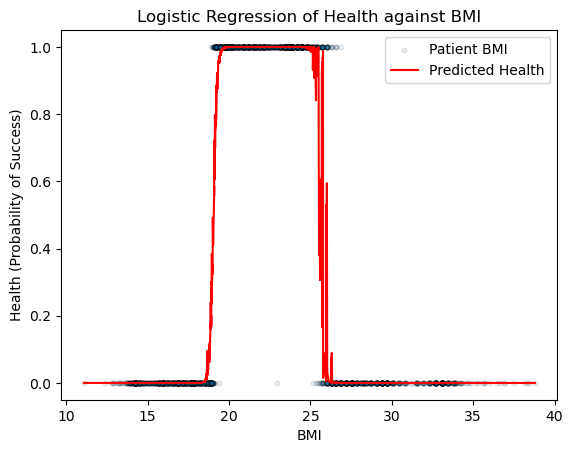

In [117]:
# Get the predicted probabilities
result = log_reg
probs = result.predict(X)

# Sort the data for plotting
sorted_indices = np.argsort(bmi_list)
X_sorted = np.asarray(bmi_list)
X_sorted = X_sorted[sorted_indices]
probs_sorted = probs[sorted_indices]
# probs_sorted = probs
# Plot the logistic regression curve
plt.scatter(bmi_list, output_list, s=10, alpha=0.1, edgecolors="k", label='Patient BMI')
plt.plot(X_sorted, probs_sorted, color='red', label='Predicted Health')
plt.xlabel('BMI')
plt.ylabel('Health (Probability of Success)')
plt.title('Logistic Regression of Health against BMI')
plt.legend()
plt.savefig('medqa_logistic_regression_bmi.png')
plt.show()